In [42]:
import os
if os.path.basename(os.path.abspath(".")) == "notebooks":
    os.chdir("..")

import argparse
import random
import shutil
import pprint
import time
import os
import cv2
import json
import pickle
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import datetime
import torchvision
from tqdm import tqdm
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torch
from torch import autocast
from contextlib import contextmanager, nullcontext
from src.datasets import get_dataset
from src.foreground_masks import GMMMaskSuggestor
from src.preliminary_masks import preprocess_attention_maps
from src.visualization.utils import word_to_slice
from src.visualization.utils import MIMIC_STRING_TO_ATTENTION
from src.visualization.utils import model_to_viz
from log import logger, log_experiment
from sklearn.metrics import jaccard_score
from log import logger, log_experiment
from log import formatter as log_formatter
from tqdm import tqdm
import logging
from utils import get_compute_mask_args, make_exp_config, load_model_from_config, collate_batch, img_to_viz
from einops import reduce, rearrange, repeat
from pytorch_lightning import seed_everything
from mpl_toolkits.axes_grid1 import ImageGrid
from omegaconf import OmegaConf
from src.ldm.util import instantiate_from_config
from src.ldm.util import AttentionSaveMode
from src.ldm.models.diffusion.plms import PLMSSampler
from src.preliminary_masks import reorder_attention_maps, normalize_attention_map_size
from src.ldm.models.diffusion.ddim import DDIMSampler
from src.evaluation.utils import compute_metrics, compute_prediction_from_binary_mask
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.patches as patches
from src.datasets.utils import path_to_tensor
from src.ldm.encoders.modules import OpenClipDummyTokenizer

In [43]:
frozen_path = "/vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/frozen_30k.ckpt"
learnable_path = "/vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/learnable_60k.ckpt"
EXP_PATH = "/vol/ideadata/ed52egek/pycharm/chest-distillation/experiments/chestxray/test_textual_models.py"

In [44]:
results_frozen = pd.read_csv("/vol/ideadata/ed52egek/pycharm/chest-distillation/experiments/bbox_results_frozen_30k.csv")
results_sdv2 = pd.read_csv("/vol/ideadata/ed52egek/pycharm/chest-distillation/experiments/bbox_results_sdv2.csv")
results_learnable = pd.read_csv("/vol/ideadata/ed52egek/pycharm/chest-distillation/experiments/bbox_results_learnable_60k.csv")

["Atelectasis", "Cardiomegaly", "Consolidation", "Lung Opacity", "Edema", "Pneumonia", "Pneumothorax", "Pleural Effusion"]

results_frozen.groupby("finding_labels")["cnr"].mean()

finding_labels
Atelectasis         1.301726
Cardiomegaly        0.742398
Consolidation       1.293900
Edema               1.349014
Lung Opacity        1.072325
Pleural Effusion    1.087658
Pneumonia           1.198498
Pneumothorax        0.586676
Name: cnr, dtype: float64

In [48]:
mscxr = pd.read_csv("/vol/ideadata/ed52egek/data/mimic/jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/bbox_mscxr_meta.csv")
mscxr

,dicom_id,category_name,label_text,path,x,y,w,h,image_width,image_height,paths
0,675d792f-a3521e48-5eec8573-1e81d644-e60c34f8,Pneumonia,Bibasilar opacities,files/p10/p10233088/s54276838/675d792f-a3521e4...,196,1136,532,315,1767,2021,files/p10/p10233088/s54276838/675d792f-a3521e4...
1,675d792f-a3521e48-5eec8573-1e81d644-e60c34f8,Pneumonia,Bibasilar opacities,files/p10/p10233088/s54276838/675d792f-a3521e4...,1009,1134,491,350,1767,2021,files/p10/p10233088/s54276838/675d792f-a3521e4...
2,5318d353-daae9c3d-2ee8648e-32b65198-aeff801e,Pneumonia,Bilateral multifocal areas of consolidation,files/p10/p10123147/s50230934/5318d353-daae9c3...,1510,1268,755,796,2539,3050,files/p10/p10123147/s50230934/5318d353-daae9c3...
3,5318d353-daae9c3d-2ee8648e-32b65198-aeff801e,Pneumonia,Bilateral multifocal areas of consolidation,files/p10/p10123147/s50230934/5318d353-daae9c3...,454,690,637,670,2539,3050,files/p10/p10123147/s50230934/5318d353-daae9c3...
4,4decce85-c6ede74e-7a8bc81c-e81edee9-5ec17116,Pneumothorax,Large right-sided pneumothorax,files/p10/p10500801/s58577720/4decce85-c6ede74...,265,90,880,2198,3056,2544,files/p10/p10500801/s58577720/4decce85-c6ede74...
...,...,...,...,...,...,...,...,...,...,...,...
1443,18e1246d-a9c790ca-6b40ea18-81b9ccc8-3469c113,Pleural Effusion,Small bilateral pleural effusions,files/p15/p15445857/s50967054/18e1246d-a9c790c...,1057,1198,760,435,1950,1826,files/p15/p15445857/s50967054/18e1246d-a9c790c...
1444,f7e3f8a3-7299389e-84a7eb76-0cb81c79-06875895,Pleural Effusion,Persistent moderate-to-large bilateral pleural...,files/p12/p12668169/s54438962/f7e3f8a3-7299389...,322,972,1076,1239,2539,3050,files/p12/p12668169/s54438962/f7e3f8a3-7299389...
1445,f7e3f8a3-7299389e-84a7eb76-0cb81c79-06875895,Pleural Effusion,Persistent moderate-to-large bilateral pleural...,files/p12/p12668169/s54438962/f7e3f8a3-7299389...,1755,907,748,1304,2539,3050,files/p12/p12668169/s54438962/f7e3f8a3-7299389...
1446,0677ec27-61328435-0dfee3b9-356bfc03-8cbd3353,Pleural Effusion,Small bilateral pleural effusions are presumed,files/p13/p13859188/s52811469/0677ec27-6132843...,601,1515,998,412,3056,2544,files/p13/p13859188/s52811469/0677ec27-6132843...


In [38]:
results_frozen["cnr"] =   results_frozen["cnr"].apply(abs)
print(f"avg: {results_frozen['cnr'].mean()}" )
results = results_frozen.groupby("finding_labels")["cnr"].mean()
results

avg: 0.9439370765639368


finding_labels
Atelectasis         1.301726
Cardiomegaly        0.747803
Consolidation       1.293900
Edema               1.349014
Lung Opacity        1.075007
Pleural Effusion    1.087658
Pneumonia           1.198498
Pneumothorax        0.588971
Name: cnr, dtype: float64

In [40]:
" & ".join([str(int(results[x]*100)/100) for x in ["Atelectasis", "Cardiomegaly", "Consolidation", "Lung Opacity", "Edema", "Pneumonia", "Pneumothorax", "Pleural Effusion"]])

'1.3 & 0.74 & 1.29 & 1.07 & 1.34 & 1.19 & 0.58 & 1.08'

In [5]:
results = results[results["top1"] == 1.0]

In [6]:
best_aucroc = results.iloc[results["aucroc"].argmax()]

In [7]:
opt = make_exp_config(EXP_PATH)
precision_scope = autocast

def get_dataset_helper(opt, model):
    opt.dataset_args_test["phrase_grounding"] = True
    dataset = get_dataset(opt, "test")
    config = OmegaConf.load(f"{opt.config_path}")

    config["model"]["params"]["use_ema"] = False
    config["model"]["params"]["unet_config"]["params"]["attention_save_mode"] = "cross"
    logger.info(f"Enabling attention save mode")

    dataset.load_precomputed(model)
    return dataset

def contrast_to_noise_ratio(ground_truth_img, prelim_mask_large):
    gt_mask = ground_truth_img.flatten()
    pr_mask = prelim_mask_large.flatten()

    roi_values = pr_mask[gt_mask == 1.0]
    not_roi_values = pr_mask[gt_mask != 1.0]

    contrast = roi_values.mean() - not_roi_values.mean()
    noise = torch.sqrt(
        roi_values.var() + not_roi_values.var()
    )
    cnr = contrast / noise
    return cnr


dataset = get_dataset_helper(opt, None)


2023-03-07 14:46:37,410 | 2927611368.py-get_dataset_helper-0011 | INFO | Enabling attention save mode
2023-03-07 14:46:37,411 | chest.py-load_precomputed-0162 | INFO | Using precomputed dataset with name: /vol/ideadata/ed52egek/data/mimic/jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/b3a6ecfe8554c2b3ce2c3ca8144175c7b2bd4020


In [8]:
def get_dataset_sample(dataset, key="rel_path", value=None):
    samples = []
    for i in range(len(dataset)):
        sample = dataset[i]
        if sample[key] == value:
            samples.append(sample)
    return samples


In [9]:
import matplotlib.pyplot as plt

sample_bbox_best = get_dataset_sample(dataset, key="rel_path", value="files/p15/p15811456/s56371125/a377960e-1665d336-c57bc69a-423714c7-14a9bc28.jpg")


In [32]:

config = OmegaConf.load(f"{opt.config_path}")
config["model"]["params"]["use_ema"] = False
config["model"]["params"]["unet_config"]["params"]["attention_save_mode"] = "cross"
model_frozen = load_model_from_config(config, f"{frozen_path}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_frozen = model_frozen.to(device)


Loading model from /vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/frozen_30k.ckpt
Global Step: 30000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
2023-03-07 15:00:12,665 | ddpm.py-__init__-0143 | INFO | Unconditional guidance probability: 0.0
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
2023-03-07 15:00:13,113 | factory.py-create_model-0152 | INFO | Loaded ViT-H-14 model config.
2023-03-07 15:00:21,454 | factory.py-create_model-0199 | INFO | Loading pretrained ViT-H-14 weights (laion2b_s32b_b79k).


In [34]:
def get_prediction(model, sample):
    samples = sample
    if isinstance(samples["label_text"], str):
        samples["label_text"] = [samples["label_text"], ]

    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                #img = model.log_images(samples, cond_key="label_text", unconditional_guidance_scale=1.0, inpaint=False)
                #samples["label_text"] = [str(x.split("|")[0]) for x in samples["label_text"]]
                #samples["impression"] = samples["label_text"]

                images = model.log_images(samples, N=len(samples["label_text"]), split="test", sample=False, inpaint=True,
                                              plot_progressive_rows=False, plot_diffusion_rows=False,
                                              use_ema_scope=False, cond_key="label_text", mask=1.,
                                              save_attention=True)
                attention_maps = images.pop("attention")
                attention_images = preprocess_attention_maps(attention_maps, on_cpu=False)
                attention = attention_images[0]

                txt_label = samples["label_text"][0]

                # determine tokenization
                txt_label = txt_label.split("|")[0]
                token_lens = model.cond_stage_model.compute_word_len(txt_label.split(" "))
                token_positions = list(np.cumsum(token_lens) + 1)
                token_positions = [1,] + token_positions
                label = samples["finding_labels"]
                query_words = MIMIC_STRING_TO_ATTENTION[label]

                locations = word_to_slice(txt_label.split(" "), query_words)
                #if len(locations) == 0:
                #    # use all
                #    tok_attention = attention[-40:,:,token_positions[0]:token_positions[-1]]
                #    tok_attentions.append(tok_attention.mean(dim=(0,1,2)))
                #else:
                #    for location in locations:
                #        tok_attention = attention[-40:,:,token_positions[location]:token_positions[location+1]]
                #        tok_attentions.append(tok_attention.mean(dim=(0,1,2)))

                #preliminary_attention_mask = torch.stack(tok_attentions).mean(dim=(0))
                return attention, query_words, token_positions, locations

#print(sample_bbox_best[0].keys())
attention, query_words, token_positions, locations = get_prediction(model_frozen, sample_bbox_best[0])



Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


In [249]:
def to_gmm(att):
    sample = {"preliminary_mask":att}
    mask_suggestor = GMMMaskSuggestor(opt)
    binary_mask = repeat(mask_suggestor(sample, key="preliminary_mask"), "h w -> 1 h w")
    binary_mask_large = resize_to_imag_size(binary_mask.float()).round()
    return binary_mask_large.cpu().numpy()[0]

NameError: name 'to_gmm' is not defined

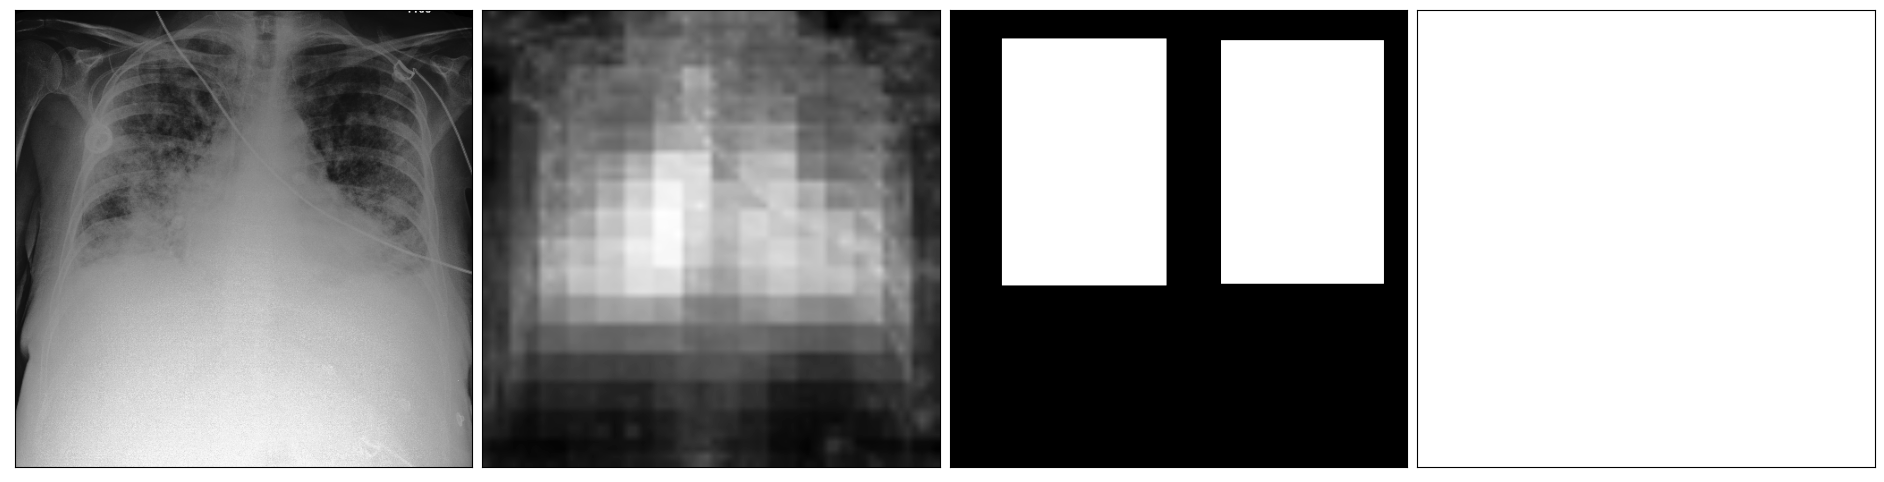

In [36]:
def attention_visualization(attention, token_positions, locations):
    tok_attentions = []
    if len(locations) == 0:
        # use all
        tok_attention = attention[-40:,:,token_positions[0]:token_positions[-1]]
        tok_attentions.append(tok_attention.mean(dim=(0,1,2)))
    else:
        for location in locations:
            tok_attention = attention[-40:,:,token_positions[location]:token_positions[location+1]]
            tok_attentions.append(tok_attention.mean(dim=(0,1,2)))
    return torch.stack(tok_attentions).mean(dim=(0))


from utils import viz_array
reduced_attention = attention_visualization(attention, token_positions, locations)

fig = plt.figure(figsize=(24, 6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True
                 )

resize_to_imag_size = torchvision.transforms.Resize(512)

prelim_attention_map = reduced_attention
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
grid[0].imshow(rearrange((sample_bbox_best[0]["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
grid[1].imshow(resize_to_imag_size(prelim_attention_map.cpu().unsqueeze(dim=0)).squeeze(), cmap="Greys_r")
grid[2].imshow(sample_bbox_best[0]["bbox_img"], cmap="Greys_r")
grid[3].imshow(to_gmm(prelim_attention_map), cmap="Greys_r")

plt.tight_layout()
plt.savefig("output.pdf")




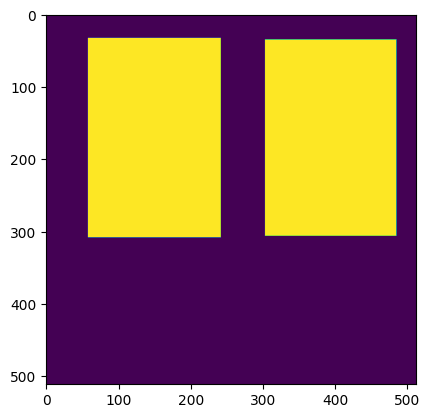

In [251]:

plt.imshow(sample_bbox_best[0]["bbox_img"])
plt.show()


['Consolidation', 'Lung Opacity']
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


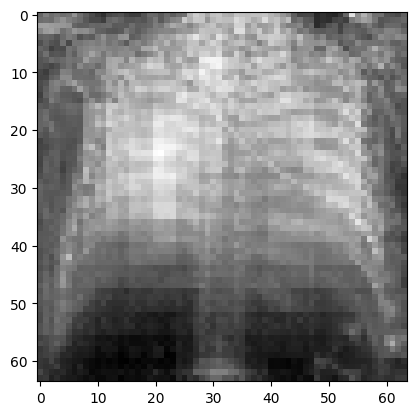

In [252]:
sample_aucroc_best = get_dataset_sample(dataset, key="rel_path", value="files/p12/p12532356/s54218174/a5d3aa8b-573aa054-cb848da6-184d98fa-539aecf3.jpg")
print([x["finding_labels"] for x in sample_aucroc_best])
#assert len(sample_aucroc_best) == 1
attention, query_words, token_positions, locations = get_prediction(model_frozen, sample_bbox_best[1])
viz_array(attention_visualization(attention, token_positions, locations))


In [253]:
best_results = results.sort_values("iou", ascending=False)[:2]


In [254]:
best_results = results.sort_values("bboxiou", ascending=False)[:2]

os.makedirs("gmmoutput", exist_ok=True)
rel_paths = best_results["rel_path"]
labels = best_results["finding_labels"]
counter = 0
for i in range(len(best_results)):
    label = labels.iloc[i]
    rel_path = rel_paths.iloc[i]
    images  = get_dataset_sample(dataset, key="rel_path", value=rel_path)
    image_labels = [x["finding_labels"] for x in images]
    if len(images) != 1:
        print(f"Image number: {i}" )
        continue


    for image in images:
        attention, query_words, token_positions, locations = get_prediction(model_frozen, image)
        reduced_attention = attention_visualization(attention, token_positions, locations)

        fig = plt.figure(figsize=(24, 6))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         share_all=True
                         )

        resize_to_imag_size = torchvision.transforms.Resize(512)

        prelim_attention_map = reduced_attention
        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])
        grid[0].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        grid[1].imshow(resize_to_imag_size(prelim_attention_map.cpu().unsqueeze(dim=0)).squeeze(), cmap="Greys_r")
        grid[2].imshow(image["bbox_img"], cmap="Greys_r")
        grid[3].imshow(to_gmm(prelim_attention_map), cmap="Greys_r")
        plt.tight_layout()
        plt.savefig(os.path.join("gmmoutput",f"{counter:05}" + ".pdf"))
        print(f"Counter: {counter}")
        print(f"Values: {best_results.iloc[i]}")
        counter += 1
plt.clf()



Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


/tmp/ipykernel_124305/4138022957.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Counter: 0
Values: Unnamed: 0                                                      632
rel_path          files/p11/p11770965/s57029912/fdb97413-86381fd...
finding_labels                                                Edema
iou                                                        0.656127
miou                                                       0.653648
bboxiou                                                    0.788993
bboxmiou                                                   0.751956
distance                                                        NaN
top1                                                            1.0
aucroc                                                     0.933326
cnr                                                        1.391422
Name: 632, dtype: object
Image number: 1


<Figure size 2400x600 with 0 Axes>

In [31]:
model_learnable = load_model_from_config(config, f"{learnable_path}")

Loading model from /vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/learnable_60k.ckpt
Global Step: 60000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
2023-03-07 14:59:46,671 | ddpm.py-__init__-0143 | INFO | Unconditional guidance probability: 0.0
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
2023-03-07 14:59:47,181 | factory.py-create_model-0152 | INFO | Loaded ViT-H-14 model config.
2023-03-07 14:59:55,928 | factory.py-create_model-0199 | INFO | Loading pretrained ViT-H-14 weights (laion2b_s32b_b79k).


In [256]:
results.groupby("rel_path")["aucroc"].mean()

rel_path
files/p10/p10002428/s55758034/3bea0373-0d10dd77-1cac5b90-651be924-d343b184.jpg    0.913051
files/p10/p10013324/s51191158/38a5ffc8-93297f03-3f0a14e4-aa8ca225-7e968b5b.jpg    0.970980
files/p10/p10018328/s51710812/7ff4e7c7-59ffae35-f3e8c04c-b3e5efc7-ba128f43.jpg    0.855248
files/p10/p10019777/s57883142/44712083-6ebbda14-6e11adaf-578d786c-b736804f.jpg    0.911047
files/p10/p10025647/s51297617/4ae3fc58-4d0f0150-48c3e754-998072f8-634033c6.jpg    0.858000
                                                                                    ...   
files/p19/p19920914/s59109767/7e513914-206a7675-fee0dc97-50ea1f20-625f5ac2.jpg    0.874193
files/p19/p19938391/s55313618/6364a269-81a5e3b8-98ec1697-7719569f-71254236.jpg    0.871666
files/p19/p19975898/s58781773/3a5d63ba-30ddd666-f1f37606-f53c9f62-439d25a7.jpg    0.841320
files/p19/p19990821/s58744660/5719f0b1-60d0c52a-3b0adefc-05403503-323fe972.jpg    0.899687
files/p19/p19997367/s58801152/1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb.jpg   

In [257]:
images = get_dataset_sample(dataset, key="rel_path", value="files/p10/p10275579/s52499441/644fbda5-196983de-2077dcd4-b4f7ecde-174a8a47.jpg")
print(len(images))
image_labels = [x["finding_labels"] for x in images]
image_labels
images[0].keys()


1


dict_keys(['dicom_id', 'rel_path', 'finding_labels', 'bboxxywh', 'label_text', 'category_name', 'img_raw', 'img', 'bbox_img'])

In [258]:
images[0]["category_name"]

'Pneumonia'

['there is diffuse consolidation and ground-glass opacities']
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
['Diffuse bilateral alveolar opacities, given history, consistent with significant fluid overload; suggest repeat radiograph after diuresis to further evaluate for additional underlying process']
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


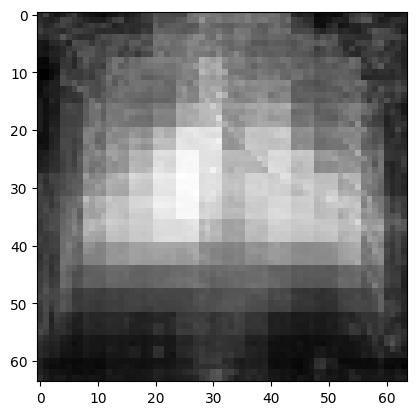

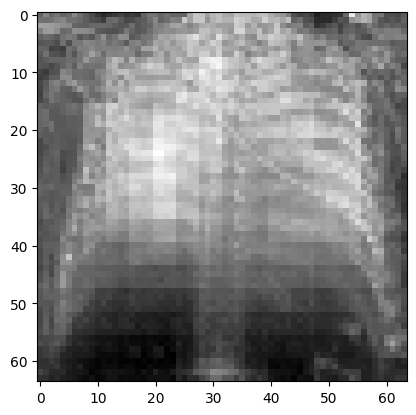

In [259]:
path = "files/p15/p15811456/s56371125/a377960e-1665d336-c57bc69a-423714c7-14a9bc28.jpg"
images = get_dataset_sample(dataset, key="rel_path", value=path)

outs = []
for image in images:
    print(image["label_text"])
    attention, query_words, token_positions, locations = get_prediction(model_frozen, image)
    reduced_attention = attention_visualization(attention, token_positions, locations)
    outs.append(reduced_attention)

viz_array(outs[0])
viz_array(outs[1])


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
dict_keys(['dicom_id', 'rel_path', 'finding_labels', 'bboxxywh', 'label_text', 'category_name', 'img_raw', 'img', 'bbox_img'])


/tmp/ipykernel_124305/2656592737.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Counter: 0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
dict_keys(['dicom_id', 'rel_path', 'finding_labels', 'bboxxywh', 'label_text', 'category_name', 'img_raw', 'img', 'bbox_img'])
Counter: 1


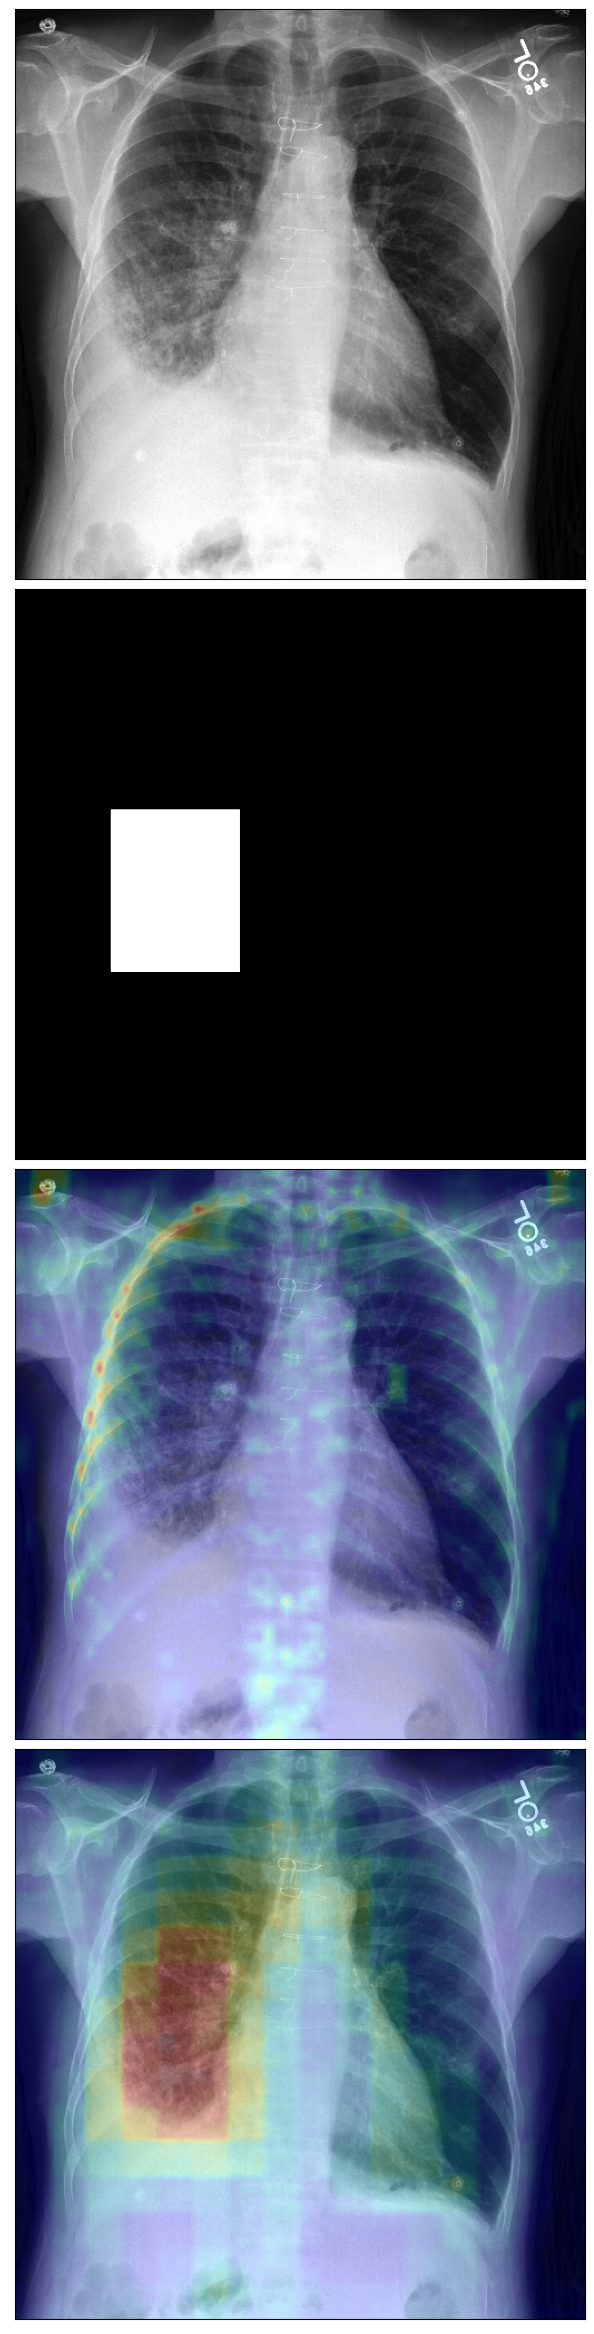

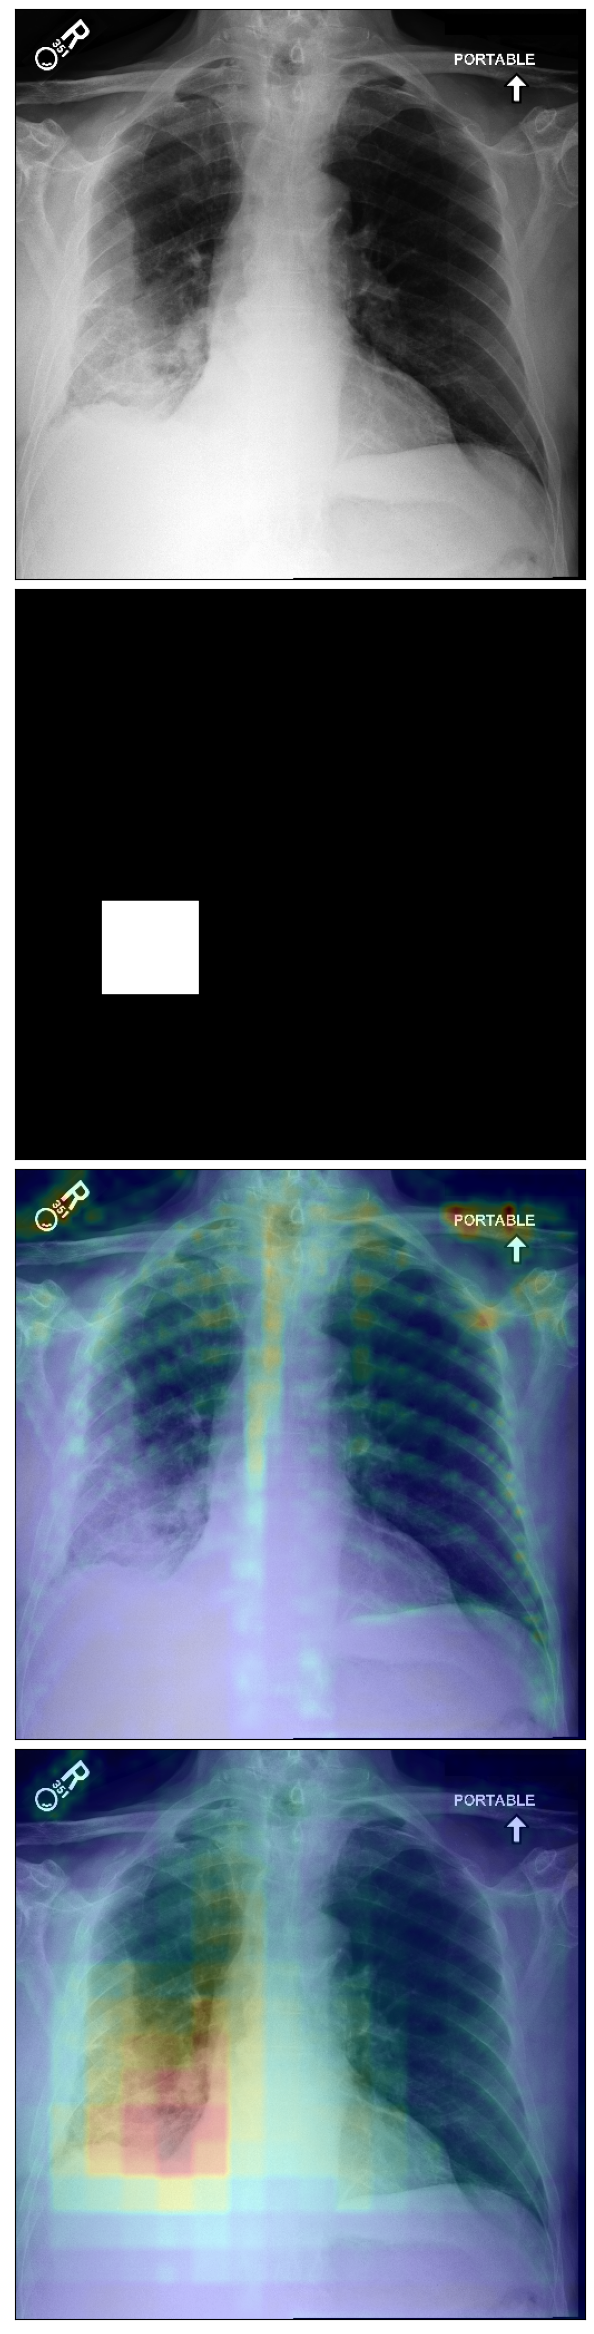

In [260]:

best_results = results.sort_values("cnr", ascending=False)[:2]

os.makedirs("miccaiout", exist_ok=True)
rel_paths = best_results["rel_path"]
labels = best_results["finding_labels"]
counter = 0
for i in range(len(best_results)):
    label = labels.iloc[i]
    rel_path = rel_paths.iloc[i]
    images  = get_dataset_sample(dataset, key="rel_path", value=rel_path)
    image_labels = [x["finding_labels"] for x in images]

    if len(images) != 1:
        print(f"Image number: {i}" )
        continue


    for image in images:
        attentionfrozen, query_wordsfrozen, token_positionsfrozen, locationsfrozen = get_prediction(model_frozen, image)
        reduced_attentionfrozen = attention_visualization(attentionfrozen, token_positionsfrozen, locationsfrozen)
        reduced_attentionfrozen = (reduced_attentionfrozen - reduced_attentionfrozen.min()) / (reduced_attentionfrozen.max() - reduced_attentionfrozen.min())

        attentionlearnable, query_wordslearnable, token_positionslearnable, locationslearnable = get_prediction(model_learnable, image)
        reduced_attentionlearnable = attention_visualization(attentionlearnable, token_positionslearnable, locationslearnable)
        reduced_attentionlearnable = (reduced_attentionlearnable - reduced_attentionlearnable.min()) / ( reduced_attentionlearnable.max() - reduced_attentionlearnable.min())

        print(image.keys())
        fig = plt.figure(figsize=(6, 24))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(4, 1),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         share_all=True
                         )

        resize_to_imag_size = torchvision.transforms.Resize(512)

        prelim_attention_mapfrozen = reduced_attentionfrozen
        prelim_attention_maplearnable = reduced_attentionlearnable
        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])
        grid[0].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        grid[1].imshow(image["bbox_img"], cmap="Greys_r")

        alpha = 0.25
        grid[2].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        grid[2].imshow(resize_to_imag_size(prelim_attention_maplearnable.cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)

        grid[3].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        grid[3].imshow(resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)

        cnr_frozen = float(contrast_to_noise_ratio(image["bbox_img"], resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0))))
        cnr_learnable = float(contrast_to_noise_ratio(image["bbox_img"], resize_to_imag_size(prelim_attention_maplearnable.cpu().unsqueeze(dim=0))))

        plt.tight_layout()

        plt.savefig(os.path.join("miccaiout", f"label_text_{image['label_text']}_cnrfro{cnr_frozen}_cnrlearn{cnr_learnable}_findingLabel{image['finding_labels']}" + ".png"))
        print(f"Counter: {counter}")
        #print(f"Values: {best_results.iloc[i]}")
        counter += 1


In [261]:
image.keys()

dict_keys(['dicom_id', 'rel_path', 'finding_labels', 'bboxxywh', 'label_text', 'category_name', 'img_raw', 'img', 'bbox_img'])

In [11]:
best_results = results.sort_values("aucroc", ascending=False)[:4]

os.makedirs("shortcut", exist_ok=True)
rel_paths = best_results["rel_path"]
labels = best_results["finding_labels"]
counter = 0

viz_upto = 10

for i in range(len(best_results)):
    label = labels.iloc[i]
    rel_path = rel_paths.iloc[i]
    images  = get_dataset_sample(dataset, key="rel_path", value=rel_path)
    image_labels = [x["finding_labels"] for x in images]

    if len(images) != 1:
        print(f"Image number: {i}" )
        continue


    for image in images:
        attentionfrozen, query_wordsfrozen, token_positionsfrozen, locationsfrozen = get_prediction(model_frozen, image)
        #reduced_attentionfrozen = attention_visualization(attentionfrozen, token_positionsfrozen, locationsfrozen)
        #reduced_attentionfrozen = (reduced_attentionfrozen - reduced_attentionfrozen.min()) / (reduced_attentionfrozen.max() - reduced_attentionfrozen.min())
        print(attentionfrozen.size())
        print(query_wordsfrozen)
        print(token_positionsfrozen)
        print(locationsfrozen)
        print(image['label_text'])
        print(attentionfrozen.size())
        attentionlearnable, query_wordslearnable, token_positionslearnable, locationslearnable = get_prediction(model_learnable, image)
        #reduced_attentionlearnable = attention_visualization(attentionlearnable, token_positionslearnable, locationslearnable)
        #reduced_attentionlearnable = (reduced_attentionlearnable - reduced_attentionlearnable.min()) / ( reduced_attentionlearnable.max() - reduced_attentionlearnable.min())

        print(image.keys())
        fig = plt.figure(figsize=(viz_upto + 2, 2))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(1, 2 + viz_upto),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         share_all=True
                         )

        resize_to_imag_size = torchvision.transforms.Resize(512)

        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])
        grid[0].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        grid[1].imshow(image["bbox_img"], cmap="Greys_r")
        alpha = 0.25

        for j in range(viz_upto):
            grid[2 + j].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
            grid[2 + j].imshow(resize_to_imag_size(attentionlearnable[-40:,:,j].mean(dim=(0,1)).cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)

        #grid[3].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        #grid[3].imshow(resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)

        #cnr_frozen = float(contrast_to_noise_ratio(image["bbox_img"], resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0))))
        #cnr_learnable = float(contrast_to_noise_ratio(image["bbox_img"], resize_to_imag_size(prelim_attention_maplearnable.cpu().unsqueeze(dim=0))))

        plt.tight_layout()
        plt.savefig(os.path.join("shortcut", f"learnable_label_text_{image['label_text']}_cnr_{cnr_learnable}_findingLabel{image['finding_labels']}" + ".png"))
        plt.show()

        print(image.keys())
        fig = plt.figure(figsize=(viz_upto + 2, 2))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(1, 2 + viz_upto),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         share_all=True
                         )

        resize_to_imag_size = torchvision.transforms.Resize(512)

        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])
        grid[0].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        grid[1].imshow(image["bbox_img"], cmap="Greys_r")
        alpha = 0.25

        for j in range(viz_upto):
            grid[2 + j].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
            grid[2 + j].imshow(resize_to_imag_size(attentionfrozen[-40:,:,j].mean(dim=(0,1)).cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)

        #grid[3].imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        #grid[3].imshow(resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)

        #cnr_frozen = float(contrast_to_noise_ratio(image["bbox_img"], resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0))))
        #cnr_learnable = float(contrast_to_noise_ratio(image["bbox_img"], resize_to_imag_size(prelim_attention_maplearnable.cpu().unsqueeze(dim=0))))

        plt.tight_layout()
        plt.savefig(os.path.join("shortcut", f"learnable_label_text_{image['label_text']}_cnr_{cnr_learnable}_findingLabel{image['finding_labels']}" + ".png"))
        plt.show()


NameError: name 'get_prediction' is not defined

In [291]:
best_results = results.sort_values("aucroc", ascending=False)[:4]
result = best_results.iloc[1]
entry = get_dataset_sample(dataset, key="rel_path", value=result["rel_path"])
if len(entry) != 1:
    print(f"Warning for {result['rel_path']}")
else:
    entry = entry[0]

meta_data_entry = dataset.bbox_meta_data.loc[entry["dicom_id"]]
if isinstance(meta_data_entry, pd.DataFrame):
    meta_data_entry = meta_data_entry[meta_data_entry["category_name"] == entry["finding_labels"]]
    assert len(meta_data_entry) == 1
    meta_data_entry = meta_data_entry.iloc[0]

image_width, image_height = meta_data_entry[["image_width", "image_height"]]
bboxes = meta_data_entry["bboxxywh"].split("|")
#bbox_img = torch.zeros((image_height, image_width), dtype=bool)

#for bbox in bboxes:
#    bbox = bbox.split("-")
#    bbox = tuple(map(lambda y: int(y), bbox))
#    x, y, w, h = bbox
#    bbox_img[y: (y + h), x:(x + w)] = True



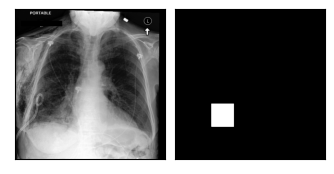

In [293]:
fig = plt.figure(figsize=(4, 2))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1,2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True
                 )

resize_to_imag_size = torchvision.transforms.Resize(512)

grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
grid[0].imshow(rearrange((entry["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
grid[1].imshow(entry["bbox_img"], cmap="Greys_r")
alpha = 0.2

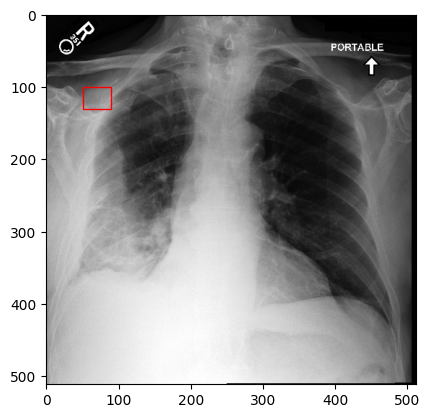

In [304]:
bboxes = []
for bbox in entry["bboxxywh"].split("|"):
    bbox = bbox.split("-")
    bbox = tuple(map(lambda y: int(y), bbox))
    bboxes.append(bbox)
bboxes

import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c"))


rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)


In [29]:
def rescale(x, y, w, h, image_height, image_width):
    print(x, y, w, h, image_height, image_width)
    resize_factor = 512 / min(image_width, image_height)
    x = int(x * resize_factor)
    y = int(y * resize_factor)
    h = int(h * resize_factor)
    w = int(w * resize_factor)

    if image_height > image_width:
        tall_image = True
    else:
        tall_image = False

    print(x, y, w, h, image_height, image_width)
    crop_size = max(image_height * resize_factor, image_width * resize_factor) - 512

    if tall_image:
        y = int(y - crop_size/2)
    else:
        x = int(x - crop_size/2)


    print(x, y, w, h, image_height, image_width)
    return x, y, w, h

In [ ]:
best_results = results.sort_values("aucroc", ascending=False)[:8]

os.makedirs("best_results", exist_ok=True)
rel_paths = best_results["rel_path"]
labels = best_results["finding_labels"]
#print(best_results)
for l in range(len(best_results)):
    result = best_results.iloc[l]
    entry = get_dataset_sample(dataset, key="rel_path", value=result["rel_path"])
    if len(entry) != 1:
        #print(f"Warning for {result['rel_path']}")
        continue
    else:
        entry = entry[0]
    #print(entry)

    meta_data_entry = dataset.bbox_meta_data.loc[entry["dicom_id"]]
    if isinstance(meta_data_entry, pd.DataFrame):
        meta_data_entry = meta_data_entry[meta_data_entry["category_name"] == entry["finding_labels"]]
        assert len(meta_data_entry) == 1
        meta_data_entry = meta_data_entry.iloc[0]

    image_width, image_height = meta_data_entry[["image_width", "image_height"]]
    image_width = int(image_width)
    image_height = int(image_height)
    bboxes = meta_data_entry["bboxxywh"].split("|")

    print(image_width, image_height)
    fig, ax = plt.subplots()
    ax.imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c"))
    ax.imshow(entry["bbox_img"])
    for bbox in bboxes:
        x,y,w,h = bbox.split("-")

        x, y, w, h = rescale(int(x), int(y), int(w), int(h), int(image_height), int(image_width))
        rect = patches.Rectangle((x, y+h), w, -1*h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


In [ ]:
best_results = results.sort_values("cnr", ascending=False)[:1]

os.makedirs("headliner", exist_ok=True)
rel_paths = best_results["rel_path"]
labels = best_results["finding_labels"]
counter = 0
for i in range(len(best_results)):
    label = labels.iloc[i]
    rel_path = rel_paths.iloc[i]
    images  = get_dataset_sample(dataset, key="rel_path", value=rel_path)
    image_labels = [x["finding_labels"] for x in images]

    if len(images) != 1:
        print(f"Image number: {i}" )
        continue


    for image in images:
        attentionfrozen, query_wordsfrozen, token_positionsfrozen, locationsfrozen = get_prediction(model_frozen, image)
        reduced_attentionfrozen = attention_visualization(attentionfrozen, token_positionsfrozen, locationsfrozen)
        reduced_attentionfrozen = (reduced_attentionfrozen - reduced_attentionfrozen.min()) / (reduced_attentionfrozen.max() - reduced_attentionfrozen.min())

        attentionlearnable, query_wordslearnable, token_positionslearnable, locationslearnable = get_prediction(model_learnable, image)
        reduced_attentionlearnable = attention_visualization(attentionlearnable, token_positionslearnable, locationslearnable)
        reduced_attentionlearnable = (reduced_attentionlearnable - reduced_attentionlearnable.min()) / ( reduced_attentionlearnable.max() - reduced_attentionlearnable.min())

        meta_data_entry = dataset.bbox_meta_data.loc[image["dicom_id"]]
        if isinstance(meta_data_entry, pd.DataFrame):
            meta_data_entry = meta_data_entry[meta_data_entry["category_name"] == image["finding_labels"]]
            assert len(meta_data_entry) == 1
            meta_data_entry = meta_data_entry.iloc[0]

        image_width, image_height = meta_data_entry[["image_width", "image_height"]]
        image_width = int(image_width)
        image_height = int(image_height)
        bboxes = meta_data_entry["bboxxywh"].split("|")
        resize_to_imag_size = torchvision.transforms.Resize(512)

        prelim_attention_mapfrozen = reduced_attentionfrozen
        prelim_attention_maplearnable = reduced_attentionlearnable


        fig, ax = plt.subplots(figsize=(6, 6))
        plt.tight_layout()
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ax.imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        plt.savefig(os.path.join("headliner", f"image_label_text_{image['label_text']}_cnrfro{cnr_frozen}_cnrlearn{cnr_learnable}_findingLabel{image['finding_labels']}" + ".png"))

        alpha = 0.2

        image_width, image_height = meta_data_entry[["image_width", "image_height"]]
        image_width = int(image_width)
        image_height = int(image_height)
        bboxes = meta_data_entry["bboxxywh"].split("|")

        fig, ax = plt.subplots(figsize=(6, 6))
        plt.tight_layout()
        ax.imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        ax.imshow(resize_to_imag_size(prelim_attention_maplearnable.cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        for bbox in bboxes:
            x,y,w,h = bbox.split("-")

            x, y, w, h = rescale(int(x), int(y), int(w), int(h), int(image_height), int(image_width))
            rect = patches.Rectangle((x, y+h), w, -1*h, linewidth=3, edgecolor='w', facecolor='none')
            ax.add_patch(rect)
        plt.savefig(os.path.join("headliner", f"learnable_label_text_{image['label_text']}_cnrfro{cnr_frozen}_cnrlearn{cnr_learnable}_findingLabel{image['finding_labels']}" + ".png"))

        alpha = 0.2
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.tight_layout()
        ax.imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
        ax.imshow(resize_to_imag_size(prelim_attention_mapfrozen.cpu().unsqueeze(dim=0)).squeeze(), cmap="jet", alpha=alpha)
        for bbox in bboxes:
            x,y,w,h = bbox.split("-")

            x, y, w, h = rescale(int(x), int(y), int(w), int(h), int(image_height), int(image_width))
            rect = patches.Rectangle((x, y+h), w, -1*h, linewidth=3, edgecolor='w', facecolor='none')
            ax.add_patch(rect)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        plt.savefig(os.path.join("headliner", f"frozen_label_text_{image['label_text']}_{image['finding_labels']}" + ".png"))

## Shortcut Learning

In [ ]:
best_results = results.sort_values("cnr", ascending=False)[1:2]
resize_to_imag_size = torchvision.transforms.Resize(512)

rel_paths = best_results["rel_path"]
labels = best_results["finding_labels"]
counter = 0
for i in range(len(best_results)):
    label = labels.iloc[i]
    rel_path = rel_paths.iloc[i]
    images  = get_dataset_sample(dataset, key="rel_path", value=rel_path)
    image_labels = [x["finding_labels"] for x in images]

    if len(images) != 1:
        print(f"Image number: {i}" )
        continue

    max_len = 10
    fig = plt.figure(figsize=(2, 2 + 2*max_len))
    grid = ImageGrid(fig,
                     111,  # similar to subplot(111)
                     nrows_ncols=(2 + 2*max_len, 2),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     share_all=True
                )

    for image in images:
        attentionfrozen, query_wordsfrozen, token_positionsfrozen, locationsfrozen = get_prediction(model_frozen, image)
        #attentionlearnable, query_wordslearnable, token_positionslearnable, locationslearnable = get_prediction(model_learnable, image)

        for l in range():

        #reduced_attentionfrozen = attention_visualization(attentionfrozen, token_positionsfrozen, locationsfrozen)
        #reduced_attentionfrozen = (reduced_attentionfrozen - reduced_attentionfrozen.min()) / (reduced_attentionfrozen.max() - reduced_attentionfrozen.min())

        reduced_attentionlearnable = attention_visualization(attentionlearnable, token_positionslearnable, locationslearnable)
        #reduced_attentionlearnable = (reduced_attentionlearnable - reduced_attentionlearnable.min()) / ( reduced_attentionlearnable.max() - reduced_attentionlearnable.min())

        meta_data_entry = dataset.bbox_meta_data.loc[image["dicom_id"]]
        if isinstance(meta_data_entry, pd.DataFrame):
            meta_data_entry = meta_data_entry[meta_data_entry["category_name"] == image["finding_labels"]]
            assert len(meta_data_entry) == 1
            meta_data_entry = meta_data_entry.iloc[0]

        image_width, image_height = meta_data_entry[["image_width", "image_height"]]
        image_width = int(image_width)
        image_height = int(image_height)
        bboxes = meta_data_entry["bboxxywh"].split("|")


        prelim_attention_mapfrozen = reduced_attentionfrozen
        prelim_attention_maplearnable = reduced_attentionlearnable


        fig, ax = plt.subplots(figsize=(6, 6))
        plt.tight_layout()
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ax.imshow(rearrange((image["img_raw"].squeeze() + 1) / 2, "c h w -> h w c").squeeze())
